# Node2Vec 链路预测与科研合作推荐

本 Notebook 包含：
- 数据加载与图构建
- Node2Vec (p=1,q=2) + Word2Vec (Skip-gram) 嵌入训练
- 可靠的链路预测（包含对缺失嵌入的处理）
- 输出所有节点的top5推荐结果
- Top-K 合作者推荐函数
- 可视化BFE游走过程


In [1]:
import networkx as nx
import pandas as pd
import random
import numpy as np
from node2vec import Node2Vec
from gensim.models import Word2Vec
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

random.seed(42)
np.random.seed(42)


In [2]:
edges_df = pd.read_csv('../output/edges.csv')
print('edges_df head:')
display(edges_df.head())

G = nx.Graph()
for _, row in edges_df.iterrows():
    u = int(row['node_id_1'])
    v = int(row['node_id_2'])
    w = row['weight'] if 'weight' in row.index else 1
    G.add_edge(u, v, weight=w)

print(f"原始节点数: {G.number_of_nodes()}, 边数: {G.number_of_edges()}")

isolated_nodes = [n for n, d in G.degree() if d == 0]
if isolated_nodes:
    G.remove_nodes_from(isolated_nodes)
    print(f"删除了 {len(isolated_nodes)} 个孤立节点")
else:
    print('没有孤立节点需要删除')

print(f"处理后节点数: {G.number_of_nodes()}, 边数: {G.number_of_edges()}")


edges_df head:


,node_id_1,node_id_2,year,weight
0,0,1,2024,1
1,0,2,2024,1
2,0,3,2024,1
3,0,4,2024,1
4,1,2,2024,1


原始节点数: 17992, 边数: 82189
没有孤立节点需要删除
处理后节点数: 17992, 边数: 82189


In [4]:
node2vec = Node2Vec(G, dimensions=64, walk_length=40, num_walks=20, p=1, q=2, workers=4, seed=42)
walks = node2vec.walks
walks_str = [[str(node) for node in walk] for walk in walks]

w2v_model = Word2Vec(sentences=walks_str, vector_size=64, window=5, min_count=1, sg=1, workers=4, seed=42)

embeddings = {}
for key in w2v_model.wv.index_to_key:
    try:
        node_id = int(key)
    except:
        node_id = key
    embeddings[node_id] = w2v_model.wv[key]

print(f"成功生成嵌入向量的节点数: {len(embeddings)}")


Computing transition probabilities:   0%|          | 0/17992 [00:00<?, ?it/s]

成功生成嵌入向量的节点数: 17992


In [4]:
all_edges = [(u, v) for u, v in G.edges() if (u in embeddings and v in embeddings)]
print(f"可用于链路预测的边数 (两端有嵌入): {len(all_edges)}")

if len(all_edges) < 10:
    raise ValueError('可用于测试/训练的边太少，请检查 embeddings 或图构建步骤。')

test_ratio = 0.2
num_test = max(1, int(len(all_edges) * test_ratio))
test_edges = random.sample(all_edges, num_test)
train_edges = [e for e in all_edges if e not in test_edges]

print(f"测试集边数: {len(test_edges)}, 训练集边数: {len(train_edges)}")


可用于链路预测的边数 (两端有嵌入): 82189
测试集边数: 16437, 训练集边数: 65752


In [9]:
def generate_negative_edges(emb_nodes, G, num):
    neg = set()
    emb_nodes_list = list(emb_nodes)
    trials = 0
    while len(neg) < num and trials < num * 50:
        u = random.choice(emb_nodes_list)
        v = random.choice(emb_nodes_list)
        if u == v:
            trials += 1
            continue
        if not G.has_edge(u, v):
            neg.add((u, v))
        trials += 1
    if len(neg) < num:
        print(f"警告：只生成到 {len(neg)} 个负样本（请求 {num} 个）。")
    return list(neg)

emb_nodes = set(embeddings.keys())
neg_edges = generate_negative_edges(emb_nodes, G, len(test_edges))
print(f"负样本数: {len(neg_edges)}")


负样本数: 16437


In [10]:
def cosine_similarity_vec(a, b):
    na = np.linalg.norm(a)
    nb = np.linalg.norm(b)
    if na == 0 or nb == 0:
        return 0.0
    return float(np.dot(a, b) / (na * nb))

pos_scores = []
valid_pos = []
for u, v in test_edges:
    if u in embeddings and v in embeddings:
        pos_scores.append(cosine_similarity_vec(embeddings[u], embeddings[v]))
        valid_pos.append((u,v))
    else:
        print(f"跳过正样本 {(u,v)}，因缺失嵌入")

neg_scores = []
valid_neg = []
for u, v in neg_edges:
    if u in embeddings and v in embeddings:
        neg_scores.append(cosine_similarity_vec(embeddings[u], embeddings[v]))
        valid_neg.append((u,v))
    else:
        print(f"跳过负样本 {(u,v)}，因缺失嵌入")

y_true = [1] * len(pos_scores) + [0] * len(neg_scores)
y_pred = pos_scores + neg_scores

if len(set(y_true)) == 1 or len(y_pred) == 0:
    print('样本不平衡或得分集合异常，无法计算 AUC')
else:
    auc = roc_auc_score(y_true, y_pred)
    print(f"有效正样本: {len(pos_scores)}, 有效负样本: {len(neg_scores)}")
    print(f"AUC = {auc:.8f}")


有效正样本: 16437, 有效负样本: 16437
AUC = 0.99980095


In [ ]:
def recommend_top_k(node, K=10):
    if node not in embeddings:
        raise KeyError(f"节点 {node} 没有嵌入向量，无法推荐")
    neighbors = set(G.neighbors(node))
    candidates = [n for n in embeddings.keys() if n != node and n not in neighbors]
    scores = []
    for c in candidates:
        scores.append((c, cosine_similarity_vec(embeddings[node], embeddings[c])))
    scores.sort(key=lambda x: x[1], reverse=True)
    return scores[:K]

sample_node = next(iter(embeddings.keys()))
print('示例 node:', sample_node)
print('Top-5 推荐:', recommend_top_k(sample_node, K=5))


示例 node: 1096
Top-5 推荐: [(8190, 0.6218221783638), (7574, 0.6212427616119385), (9135, 0.6191866993904114), (9133, 0.6175804138183594), (9565, 0.617135226726532)]


In [ ]:
import csv

# 定义一个函数，遍历所有节点并将推荐结果保存到CSV文件
def save_top_k_recommendations_to_csv(embeddings, G, output_file='../output/top_k_recommendations.csv', K=5):
    # 打开 CSV 文件进行写入
    with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['Node_ID', 'Top_1', 'Top_2', 'Top_3', 'Top_4', 'Top_5']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        # 写入表头
        writer.writeheader()

        # 遍历每个节点并获取Top-K推荐
        for node in range(0, 17992):  # 遍历节点 0 到 17991
            try:
                # 获取当前节点的 Top-K 推荐结果
                top_k = recommend_top_k(node, K)
                # 准备一行数据：节点ID + Top-K推荐及其相似度得分
                top_k_values = [str(tup) for tup in top_k]  # 将元组转换为字符串形式
                
                # 填写数据字典并写入
                row = {'Node_ID': node}
                for i in range(K):
                    row[f'Top_{i+1}'] = top_k_values[i]
                
                writer.writerow(row)  # 写入当前节点的推荐结果

            except KeyError:
                # 如果节点没有嵌入向量，可以选择跳过
                print(f"节点 {node} 没有嵌入向量，跳过该节点。")
                continue

    print(f"所有节点的Top-{K}推荐已保存为 {output_file}")

# 调用函数，保存所有节点的Top-5推荐结果
save_top_k_recommendations_to_csv(embeddings, G, output_file='all_top_k_recommendations.csv', K=5)


节点 11 没有嵌入向量，跳过该节点。
节点 23 没有嵌入向量，跳过该节点。
节点 224 没有嵌入向量，跳过该节点。
节点 1182 没有嵌入向量，跳过该节点。
节点 1978 没有嵌入向量，跳过该节点。
节点 2072 没有嵌入向量，跳过该节点。
节点 2843 没有嵌入向量，跳过该节点。
节点 2887 没有嵌入向量，跳过该节点。
节点 3015 没有嵌入向量，跳过该节点。
节点 3035 没有嵌入向量，跳过该节点。
节点 3373 没有嵌入向量，跳过该节点。
节点 3542 没有嵌入向量，跳过该节点。
节点 3554 没有嵌入向量，跳过该节点。
节点 4064 没有嵌入向量，跳过该节点。
节点 4076 没有嵌入向量，跳过该节点。
节点 4094 没有嵌入向量，跳过该节点。
节点 4295 没有嵌入向量，跳过该节点。
节点 4622 没有嵌入向量，跳过该节点。
节点 4627 没有嵌入向量，跳过该节点。
节点 4633 没有嵌入向量，跳过该节点。
节点 4634 没有嵌入向量，跳过该节点。
节点 4901 没有嵌入向量，跳过该节点。
节点 5181 没有嵌入向量，跳过该节点。
节点 5182 没有嵌入向量，跳过该节点。
节点 5430 没有嵌入向量，跳过该节点。
节点 5664 没有嵌入向量，跳过该节点。
节点 5850 没有嵌入向量，跳过该节点。
节点 5871 没有嵌入向量，跳过该节点。
节点 5884 没有嵌入向量，跳过该节点。
节点 6035 没有嵌入向量，跳过该节点。
节点 6036 没有嵌入向量，跳过该节点。
节点 6066 没有嵌入向量，跳过该节点。
节点 6128 没有嵌入向量，跳过该节点。
节点 6675 没有嵌入向量，跳过该节点。
节点 6688 没有嵌入向量，跳过该节点。
节点 6696 没有嵌入向量，跳过该节点。
节点 6716 没有嵌入向量，跳过该节点。
节点 6726 没有嵌入向量，跳过该节点。
节点 6727 没有嵌入向量，跳过该节点。
节点 6731 没有嵌入向量，跳过该节点。
节点 6936 没有嵌入向量，跳过该节点。
节点 7815 没有嵌入向量，跳过该节点。
节点 7843 没有嵌入向量，跳过该节点。
节点 7852 没有嵌入向量，跳过该节点。
节点 7888 没有嵌入向量，跳过该节点。
节点 7889 没有嵌入向量，

In [ ]:
import csv, os
out_path = os.path.join(os.getcwd(), '../output/node_embeddings_BFS.csv')
with open(out_path, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    header = ['node'] + [f'vec{i}' for i in range(len(next(iter(embeddings.values()))))]
    writer.writerow(header)
    for node, vec in embeddings.items():
        writer.writerow([node] + list(vec))
print('已保存嵌入到', out_path)


已保存嵌入到 e:\network\network\node_embeddings_BFS.csv


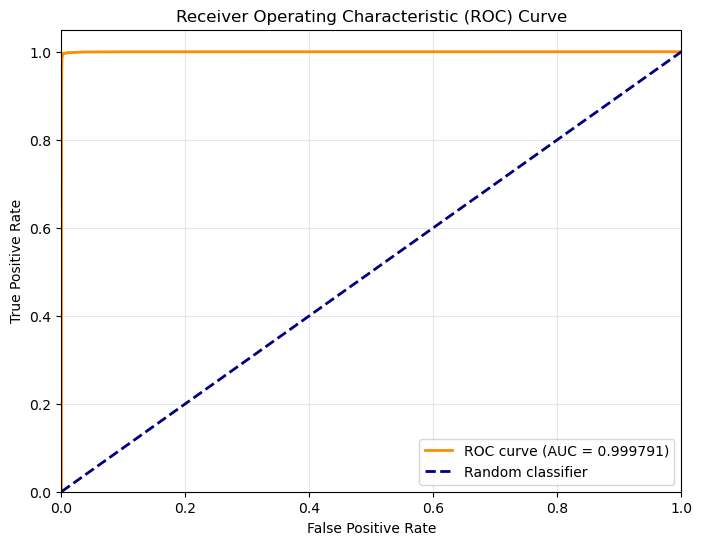

In [ ]:
# 计算ROC曲线
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# 绘制AUC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.6f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

从节点 1096 开始BFS可视化:


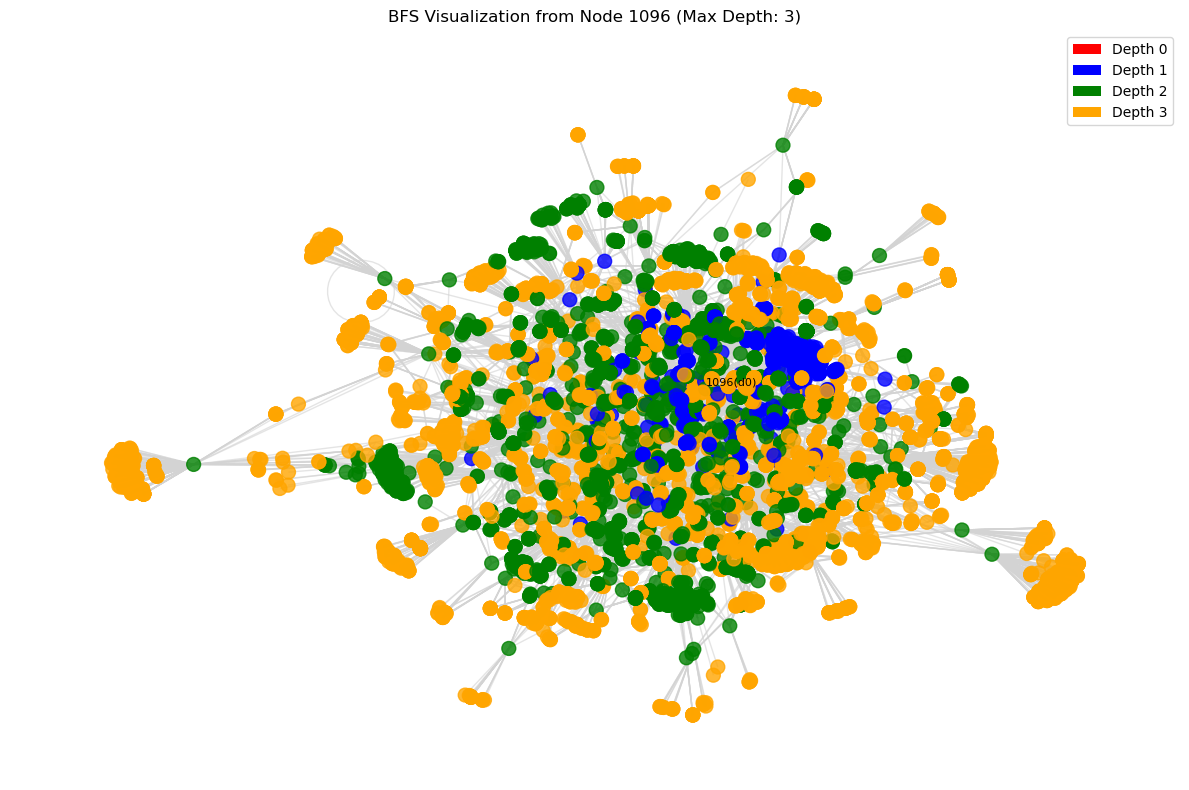

BFS从节点 1096 开始，最大深度 3:
  深度 0: 1 个节点
  深度 1: 468 个节点
  深度 2: 1822 个节点
  深度 3: 3453 个节点
  总共访问: 5744 个节点

从节点 1437 开始BFS可视化:


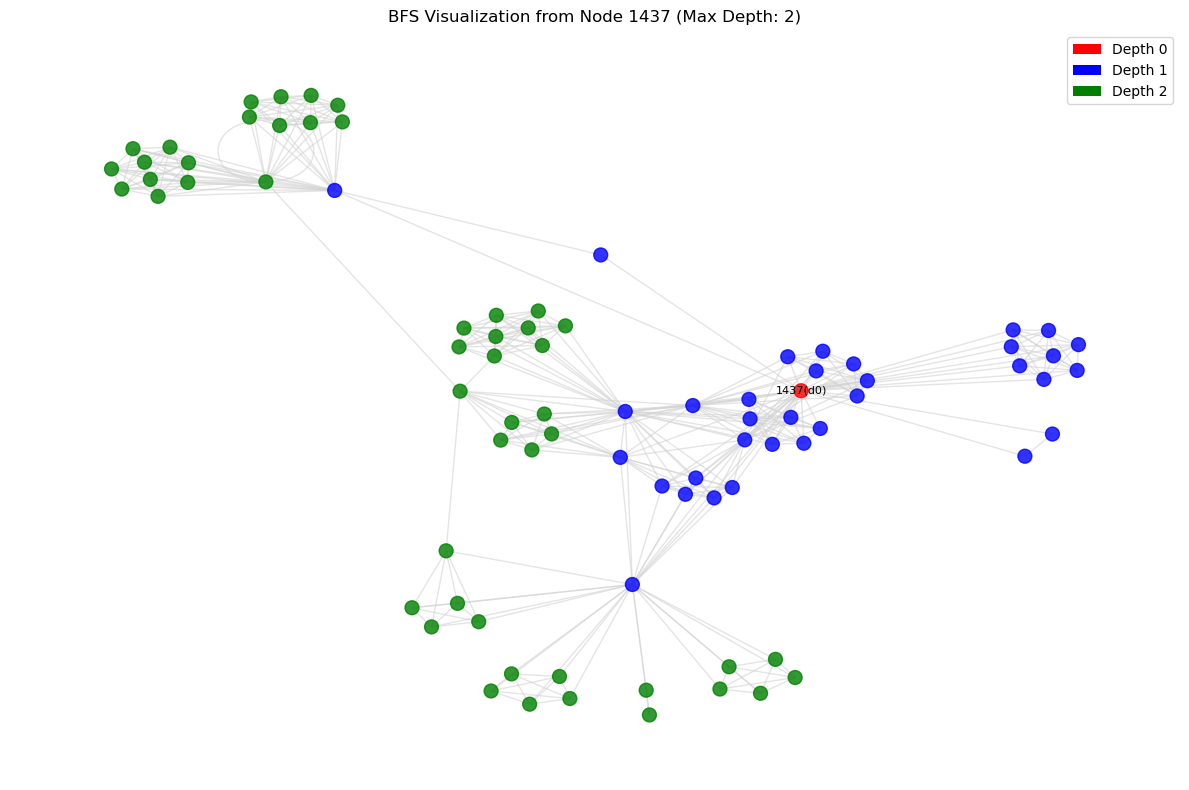

BFS从节点 1437 开始，最大深度 2:
  深度 0: 1 个节点
  深度 1: 34 个节点
  深度 2: 50 个节点
  总共访问: 85 个节点


In [ ]:
# 新增：可视化BFS并以不同颜色区分
def visualize_bfs_with_colors(start_node, max_depth=3, figsize=(12, 8)):
    """
    可视化BFS遍历，用不同颜色区分不同深度
    """
    if start_node not in G:
        print(f"节点 {start_node} 不在图中")
        return
    
    # 执行BFS
    visited = {start_node: 0}  # 节点: 深度
    queue = [start_node]
    edges_to_plot = []
    
    while queue:
        current = queue.pop(0)
        current_depth = visited[current]
        
        if current_depth >= max_depth:
            continue
            
        for neighbor in G.neighbors(current):
            if neighbor not in visited:
                visited[neighbor] = current_depth + 1
                queue.append(neighbor)
                edges_to_plot.append((current, neighbor, current_depth))
    
    # 创建子图
    subgraph_nodes = set(visited.keys())
    for u, v, depth in edges_to_plot:
        subgraph_nodes.add(u)
        subgraph_nodes.add(v)
    
    H = G.subgraph(subgraph_nodes)
    
    # 设置布局
    pos = nx.spring_layout(H, seed=42)
    
    # 设置颜色映射 - 不同深度用不同颜色
    depth_colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'orange', 4: 'purple'}
    node_colors = [depth_colors.get(visited[node], 'gray') for node in H.nodes()]
    
    # 绘制图形
    plt.figure(figsize=figsize)
    
    # 绘制边 - 用浅灰色
    nx.draw_networkx_edges(H, pos, alpha=0.6, edge_color='lightgray')
    
    # 绘制节点 - 用不同颜色表示不同深度
    nodes = nx.draw_networkx_nodes(H, pos, node_color=node_colors, 
                                  node_size=100, alpha=0.8)
    
    # 绘制标签 - 只显示起始节点和深度1的节点标签
    labels = {}
    for node in H.nodes():
        if visited[node] == 0:  # 只显示起始节点和直接邻居的标签
            labels[node] = f'{node}(d{visited[node]})'
    
    nx.draw_networkx_labels(H, pos, labels, font_size=8)
    
    # 创建图例
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=depth_colors[i], label=f'Depth {i}') 
        for i in range(max_depth + 1) if i in depth_colors
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.title(f'BFS Visualization from Node {start_node} (Max Depth: {max_depth})')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # 打印统计信息
    print(f"BFS从节点 {start_node} 开始，最大深度 {max_depth}:")
    for depth in range(max_depth + 1):
        count = sum(1 for d in visited.values() if d == depth)
        print(f"  深度 {depth}: {count} 个节点")
    print(f"  总共访问: {len(visited)} 个节点")

# 示例：从随机节点开始可视化BFS
if embeddings:
    sample_start_node = list(embeddings.keys())[0]
    print(f"从节点 {sample_start_node} 开始BFS可视化:")
    visualize_bfs_with_colors(sample_start_node, max_depth=3)
    
    # 再展示一个深度为2的例子
    if len(embeddings) > 100:
        another_node = list(embeddings.keys())[100]
        print(f"\n从节点 {another_node} 开始BFS可视化:")
        visualize_bfs_with_colors(another_node, max_depth=2)